<a href="https://colab.research.google.com/github/wuronald/F1L/blob/main/Copy_of_240702_kinker_scanpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This is a copy of a notebook by `Dean Lee` part of the F1L Intern Emulator. Specifically, this is part 2 of a series aiming to reproduce figures from *Kinker et al*, with the goal of introducing interns to computational biology and single-cell analysis.

I have added additional modifications, functions, notes and comments. Some of the additional code that I have generated using assistance from generative AI tools with modifications:

1. Colab built-in `Generate` [button](https://blog.google/technology/developers/google-colab-ai-coding-features/).
2. Claude.ai [Claude.ai](https://claude.ai/)
3. Google Gemini 1.5 via [AI studio](https://aistudio.google.com/)


# Install and Load Packages

In [ ]:
!pip install anndata
!pip install scanpy
!pip install seaborn
!pip install matplotlib

!pip install igraph
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.4 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=61f30f70fde9c14b4e54e310a38a5b3752ae7e5705e653081c5df31895a98c68
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import igraph
import leidenalg

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we use the google drive integration with Colab to mount google drive. This allows data transfer between the colab virtual machine and Google Drive.

# Load AnnData object
We previously created an AnnData object with brief pre-processing from the raw scRNA-seq data downloaded from *Kinker et al*. Let's load it from google drive.

Here we also save an unmodified version of the AnnData object that we'll test the effect of different parameters on UMAP plots.

In [ ]:
# set path to mounted gdrive
gdrive_path = '/content/drive/MyDrive/F1L/data/kinker/'

cwd = os.getcwd()
adata = sc.read_h5ad(gdrive_path+'/240701_kinker_anndata.h5ad')

# save a copy
adata_copy = adata.copy()

# Pre-Processing

In [ ]:
# function for pre-processing
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20):
    sc.pp.normalize_total(adata, target_sum=1e4) # normalize counts to total counts per cell to 1e4
    sc.pp.log1p(adata) # log transform counts
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat') # identify highly variable genes (top 2000)
    #sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack') # perform PCA
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state) # compute nearest neighbors
    sc.tl.umap(adata, random_state=random_state) # compute UMAP embedding
    sc.tl.leiden(adata, random_state=random_state) # perform Leiden clustering
    return adata

In [ ]:
# run pre-processing function on AnnData object
adata = BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

<ipython-input-6-a5fd1b59dfab>:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, random_state=random_state) # perform Leiden clustering


In [ ]:
# leiden cluster count
num_clusters = adata.obs["leiden"].nunique()
print(f'Number of Leiden clusters: {num_clusters}')
# num of unique cell lines
print(f'Number of unique cell lines: { adata.obs["CellLine"].nunique()}')

Number of Leiden clusters: 168
Number of unique cell lines: 198


# Plot UMAP

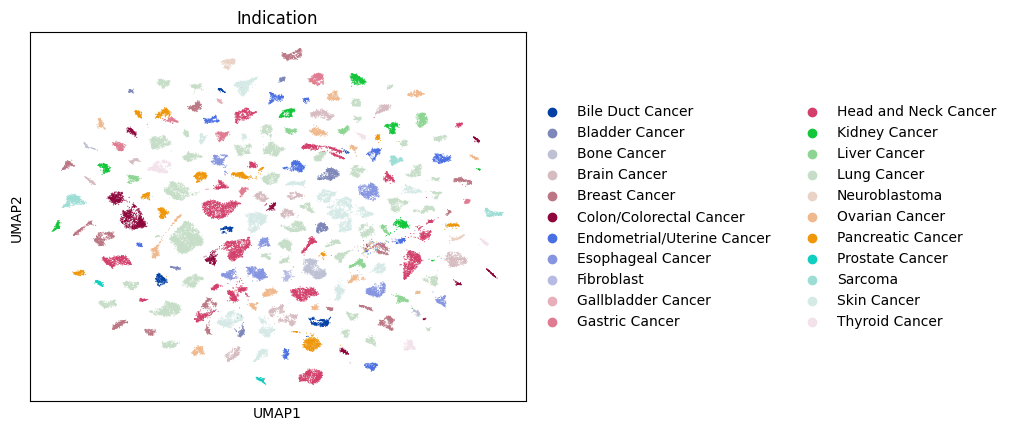

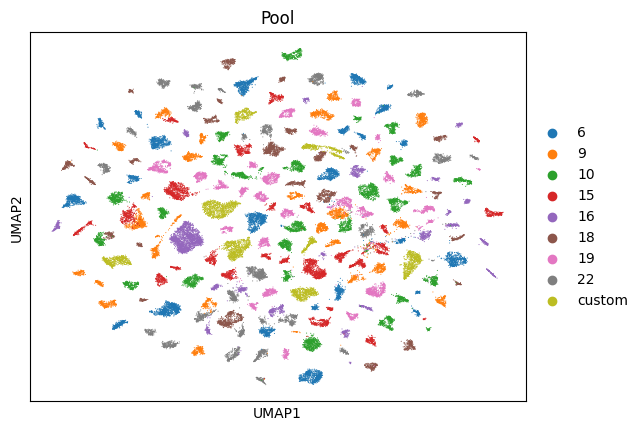

In [ ]:
sc.pl.umap(adata, color=['Indication']) # color by cancer type (indication)
sc.pl.umap(adata, color=['Pool']) # color by pool

Plots show the results of scanpy pre-processing, involving dimentionality reduction and embedding via UMAP.

Firstly, we observe a large number of clusters in the UMAP, specifically 168 Leiden clusters from 198 cell lines. When the plot is colored by **indication**, we can see most of the cells cluster by **indication**, which is the cancer type. This is expected, as we know cells from similar tissue of orgin should share more transcriptional patterns compared to cells from a different tissue of origin. However, we also observe multiple clusters often quite distant from each other within the **same** indication, suggesting differences among cell lines of the same cancer type. This could arise due biological differences, such as unique genetic mutations or epigenetic effects.

Another potential factor that could lead to these clustering patterns are technical effects, such as batch effects. We know that the authors used a unique pooling strategy that may potentially affect the results. We can plot the UMAP and colour by **pool** to see if the pooling effect had a major contribution to the clustering patterns.

When the UMAP is coloured by **pool**, we don't see a pattern of the pools being associated with a single large cluster containing a collection of multiple **indications**. In fact, we observe multiple clusters scattered across the UMAP belonging to a given pool. This suggests the Leiden clusters are not due to pooling.



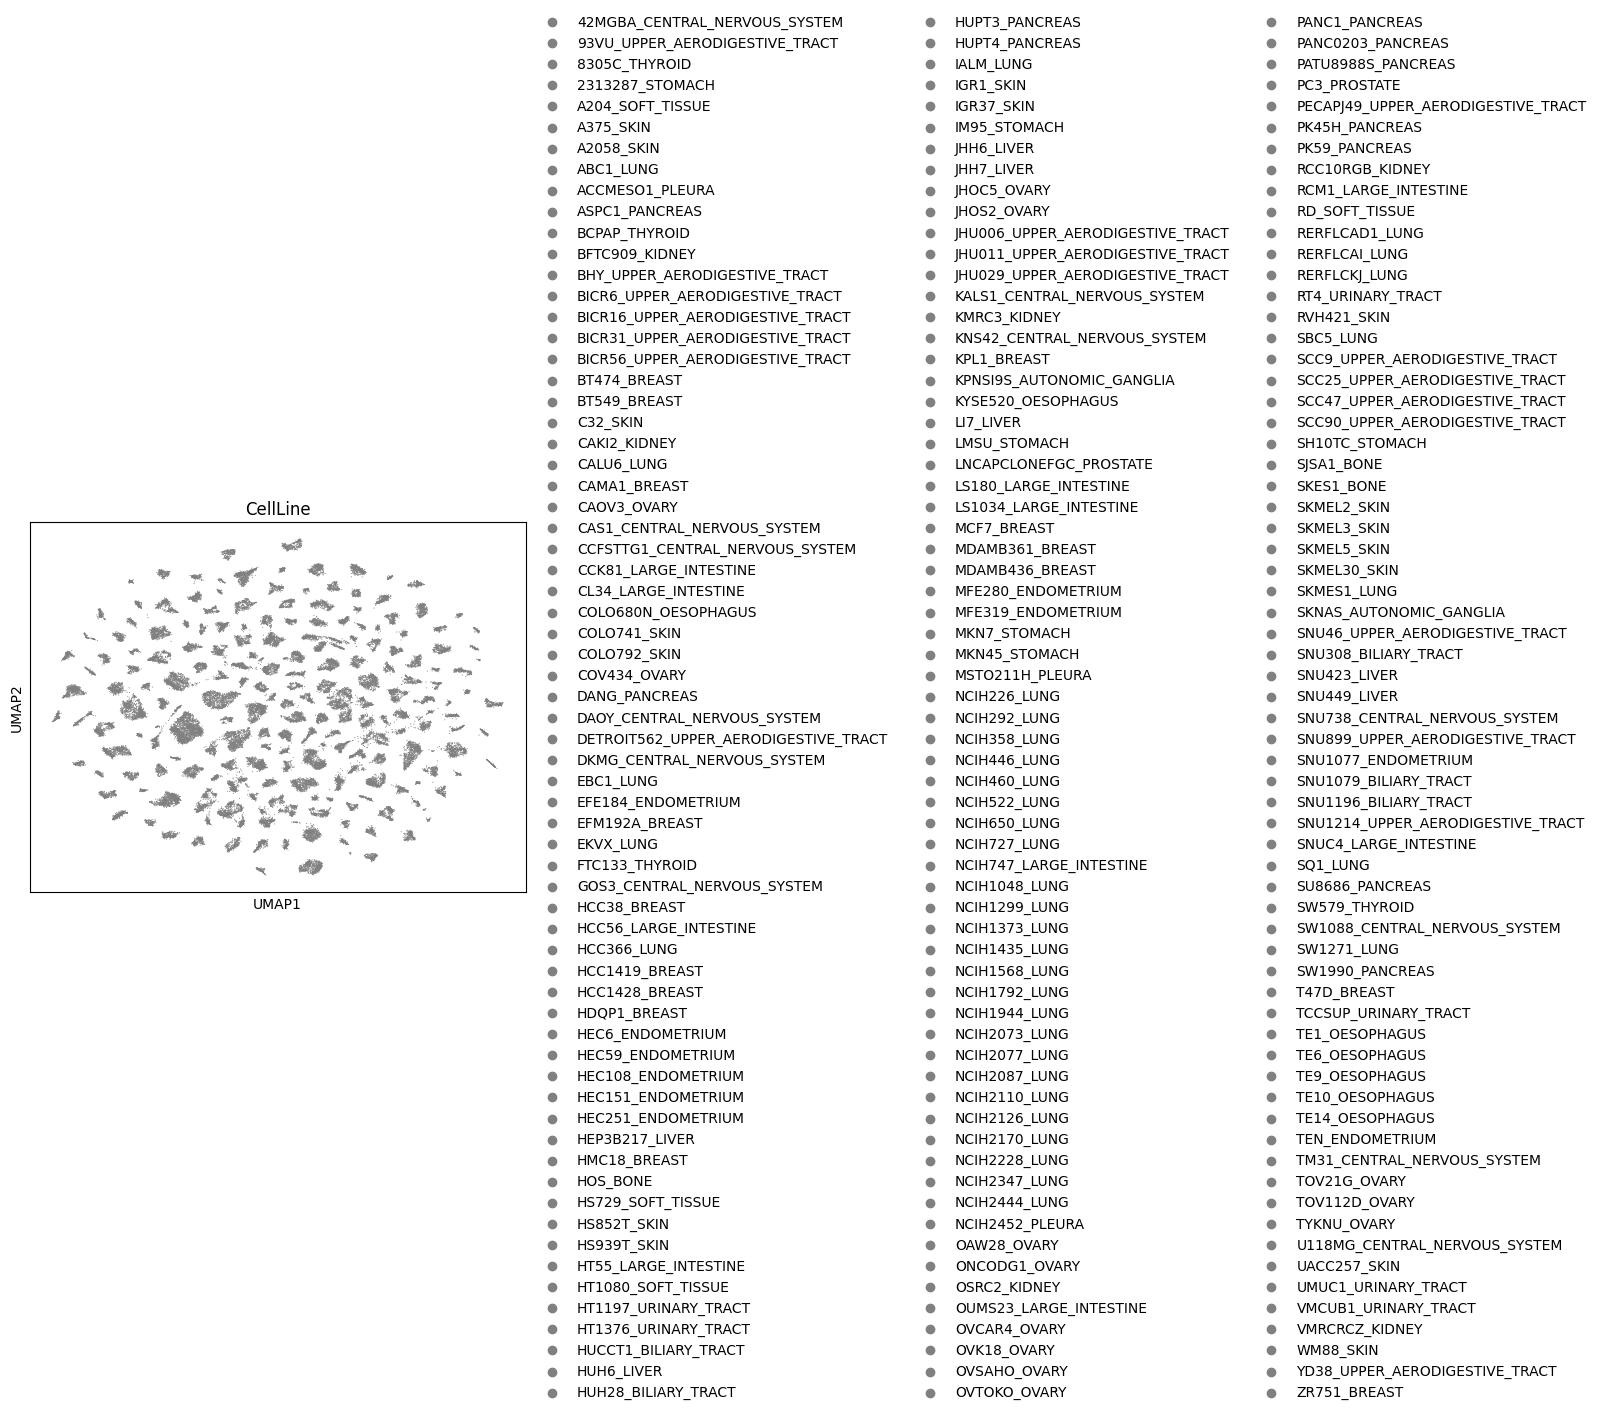

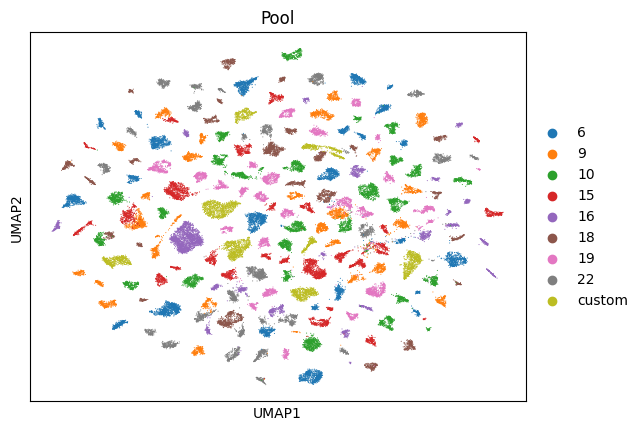

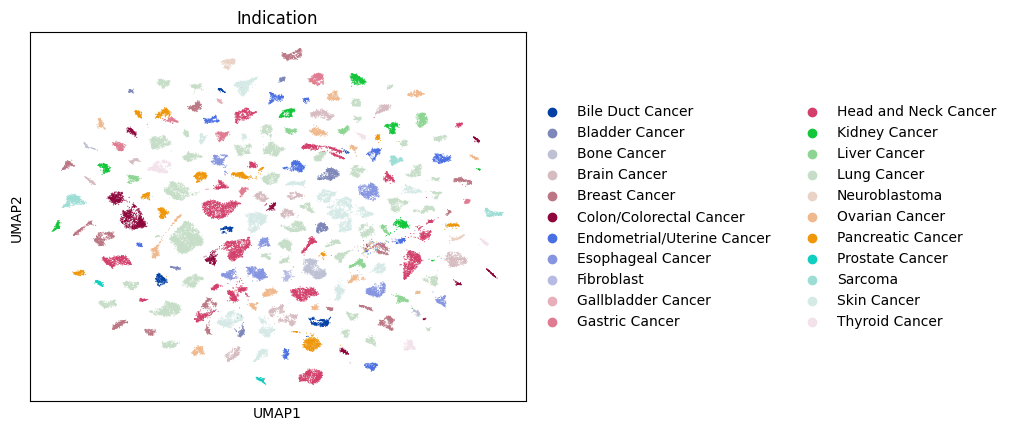

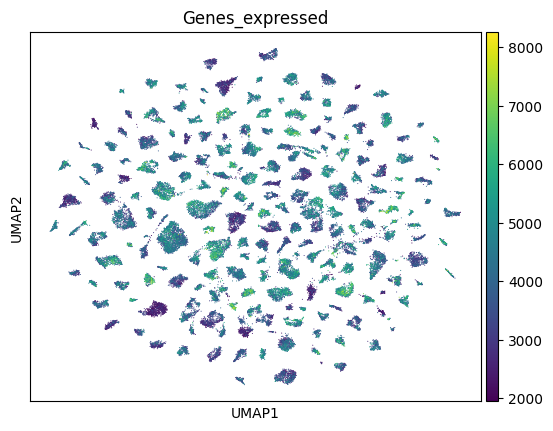

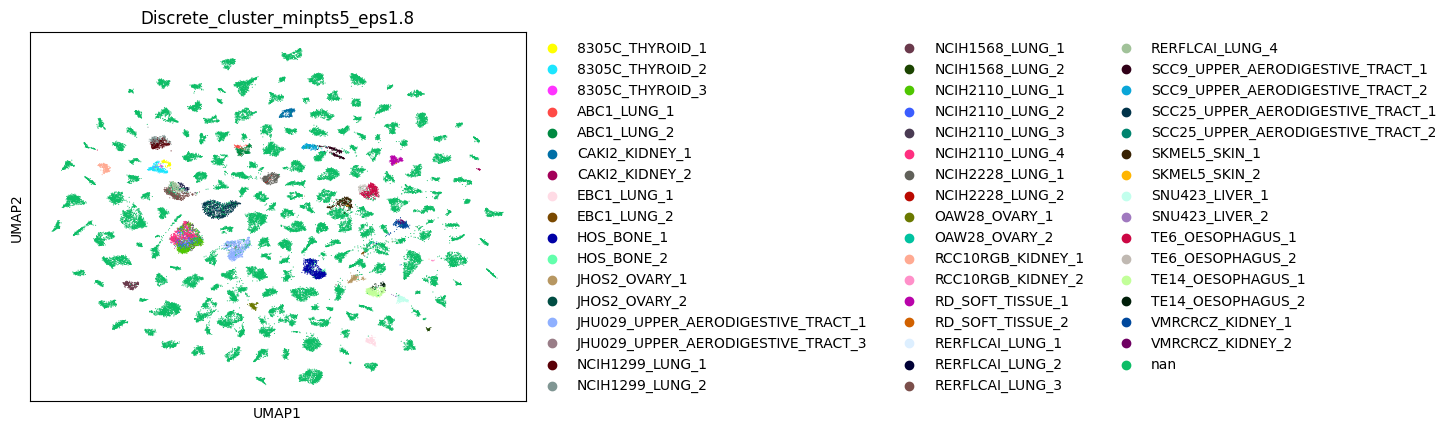

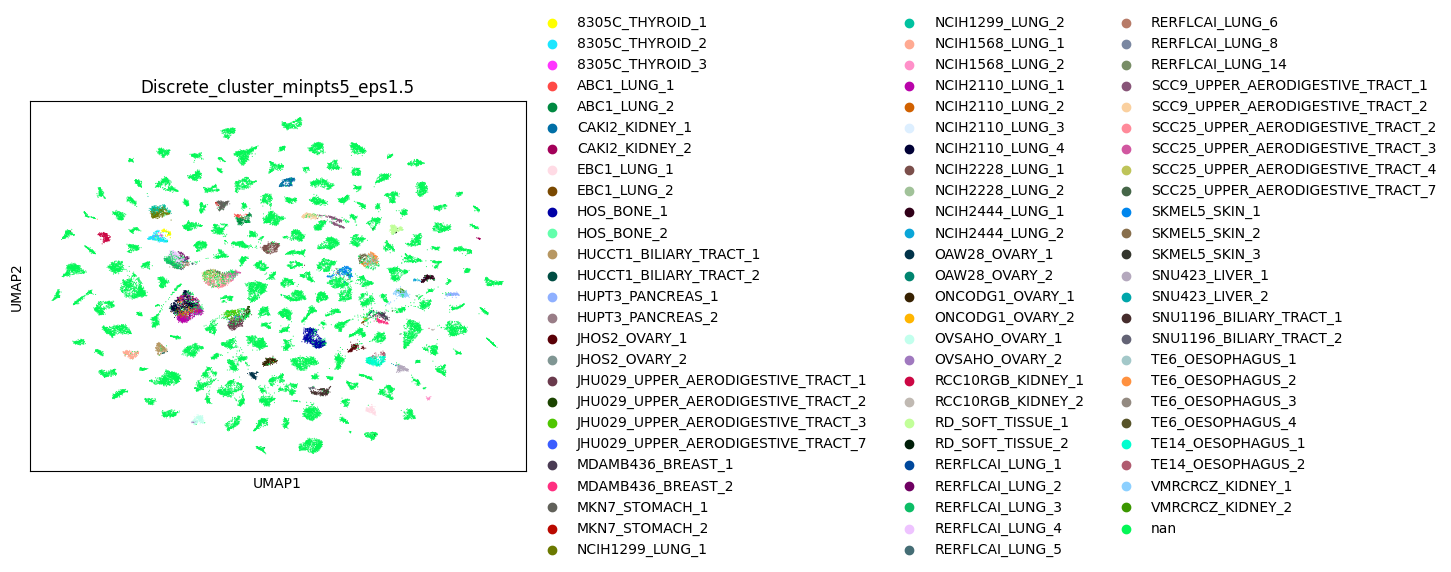

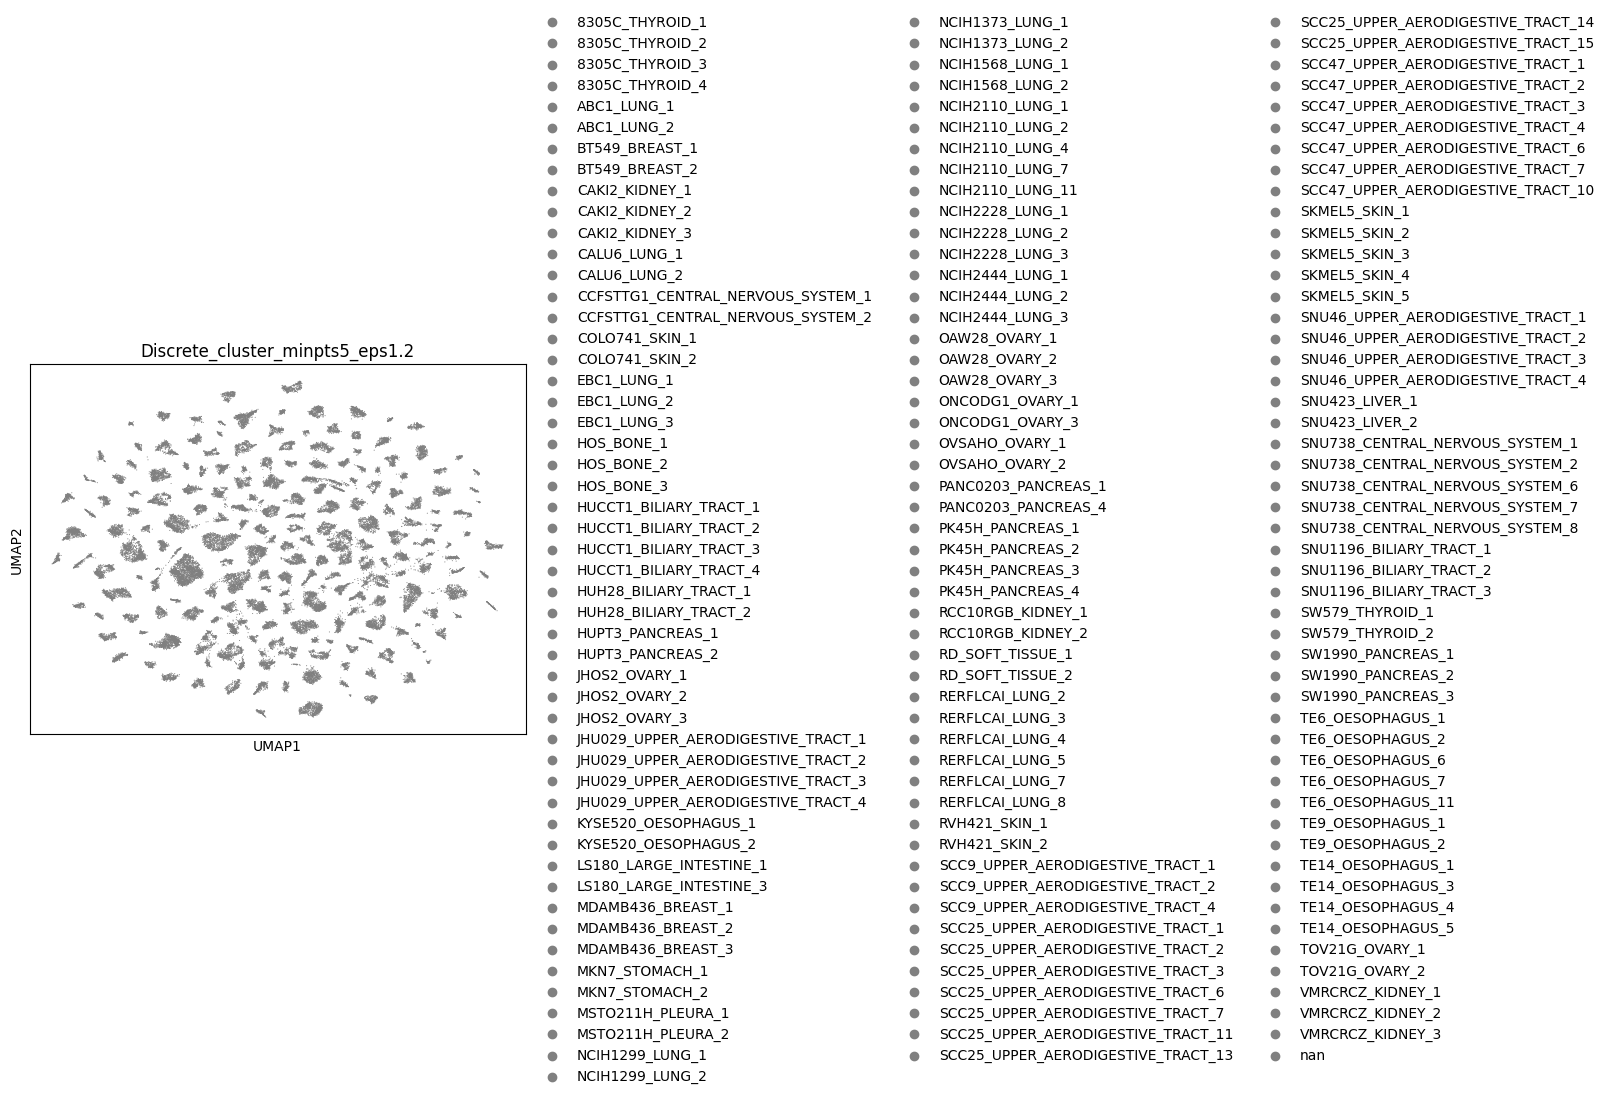

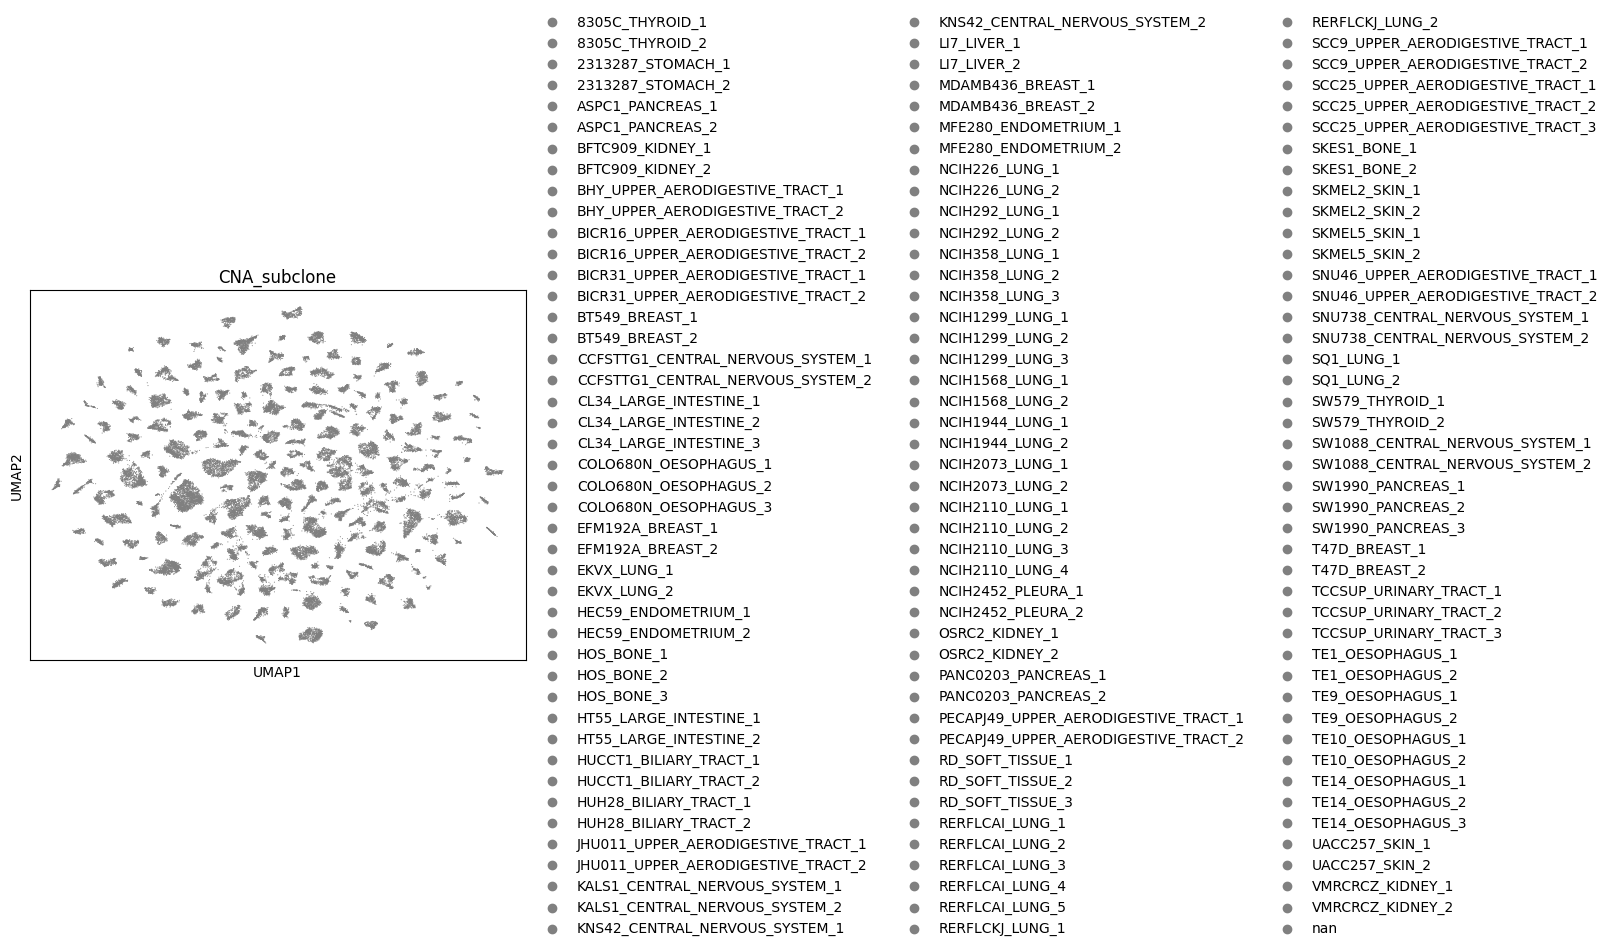

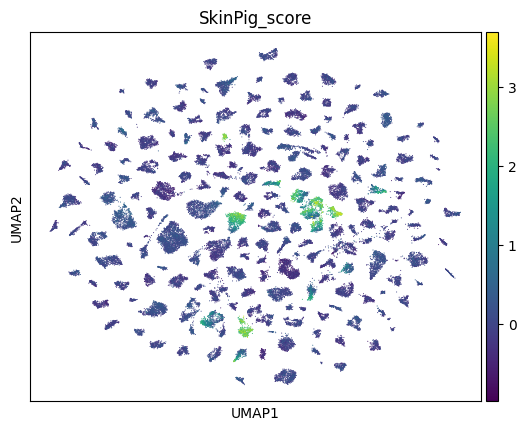

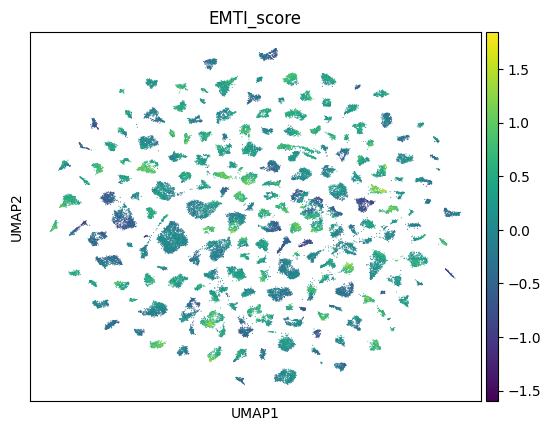

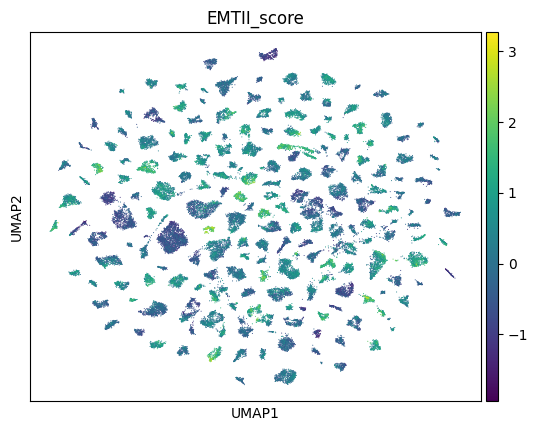

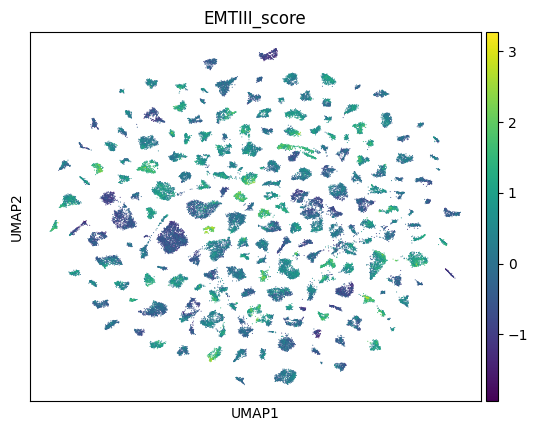

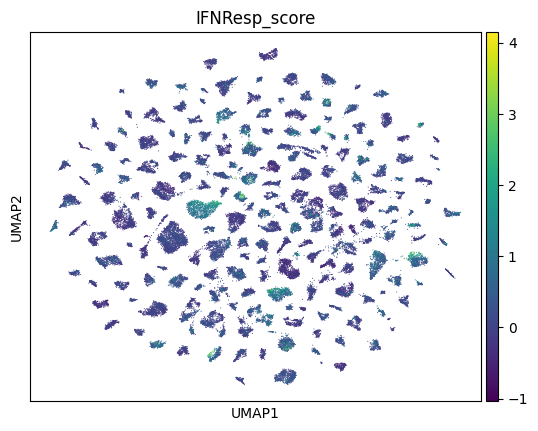

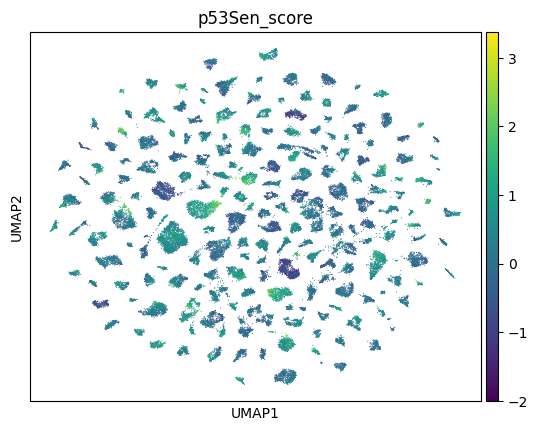

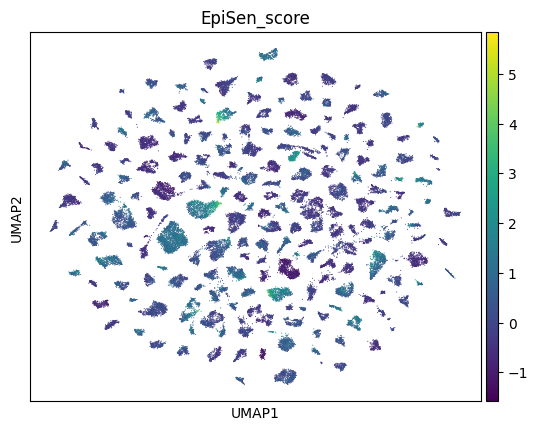

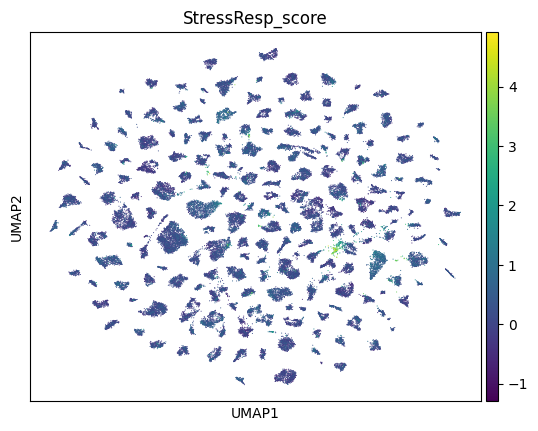

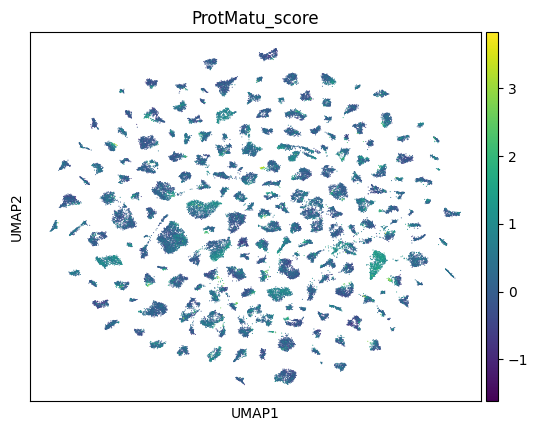

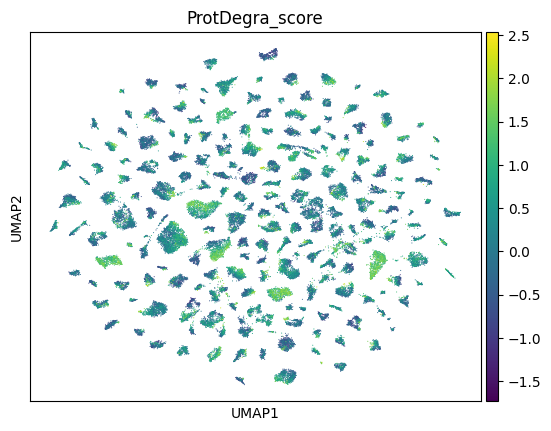

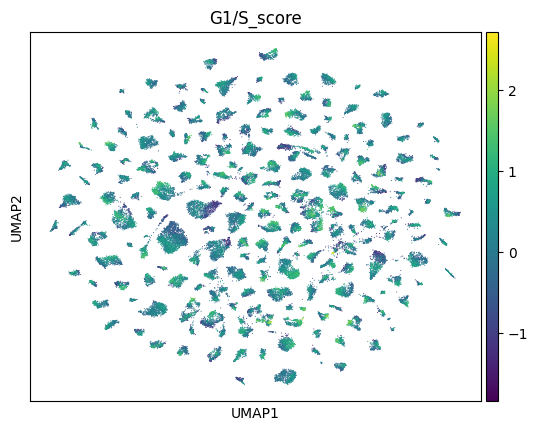

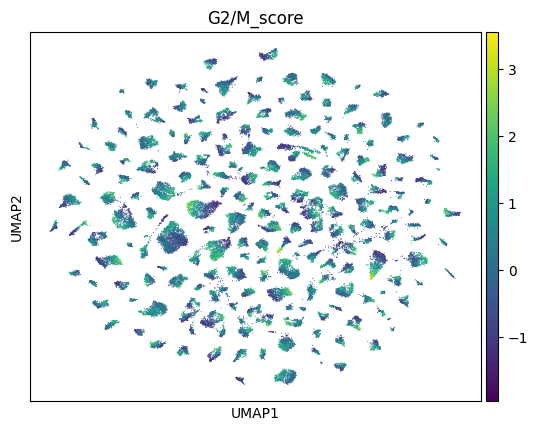

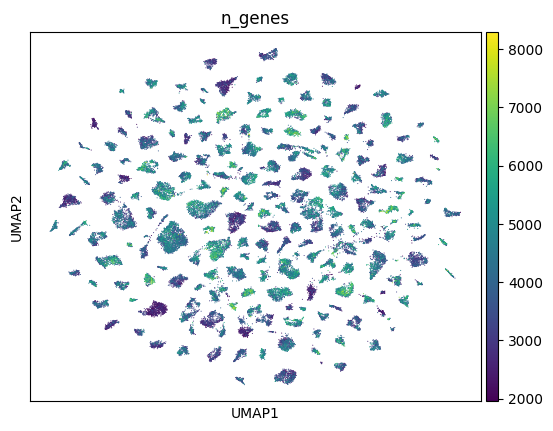

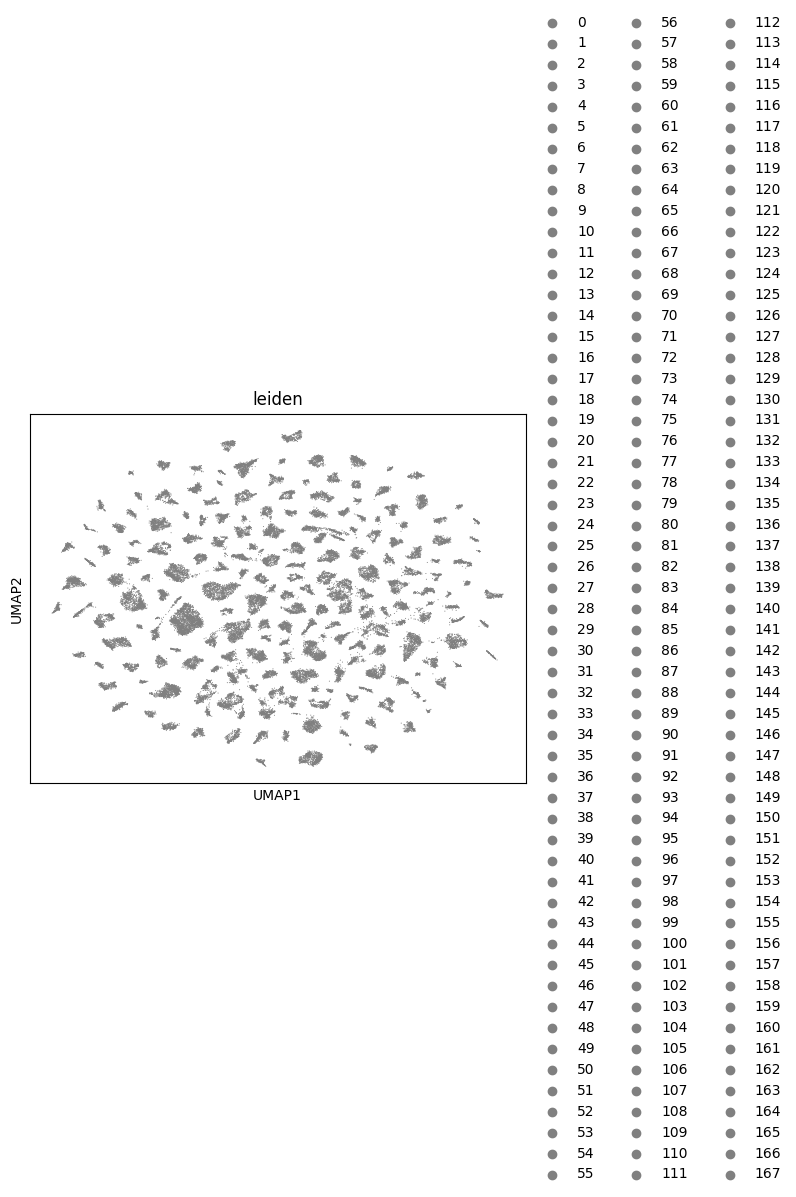

In [ ]:
# draw UMAP for each of the metadata columns
for col in adata.obs.columns:
  sc.pl.umap(adata, color=col)


# Bonus

## Reproducing Figure 2B
From *Kinker et al*, Figure 2B focuses on categorizing the types of cellular heterogeneity across cell lines. Their approach was to apply DBSCAN based clustering on a per cell line basis (individual cell lines) and identifying the number of clusters in each cell line as a measure of intracellular heterogeneity. They found that their cell lines could be categorized into 4 different types of heterogeneity based on the number and size of DBSCAN clusters:
1. \>2 clusters
2. 2 major clusters
3. major + minor clusters
4. 1 cluster


Here, we attempt to reproduce these results of Figure 2B with slight differences:
1. UMAP instead of tSNE for embedding and plotting
2. Leiden clusters instead of DBSCAN for clustering

Notably, for computational purposes, we won't run this on all the cell lines, but instead only on the cell lines shown in Figure 2B, which would be sufficient to reproduce the figure. It is expected that due to the differences mentioned above, the figure would not look identical but should convey similar findings.


In [ ]:
#print(adata_copy)
# check if those 4 cell lines in Figure 2B are in adata
#adata_copy.obs.CellLine[1:10]
adata_copy[adata_copy.obs.CellLine.str.contains('NCIH2110')].obs
adata_copy[adata_copy.obs.CellLine.str.contains('NCIH1299')].obs
adata_copy[adata_copy.obs.CellLine.str.contains('CAKI2')].obs
adata_copy[adata_copy.obs.CellLine.str.contains('JHU006')].obs


CellLine    Pool            Indication  \
c45    JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c46    JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c48    JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c51    JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c58    JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
...                                 ...     ...                   ...   
c4722  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4724  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4731  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4735  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4741  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   

       Genes_expressed Discrete_cluster_minpts5_eps1.8  \
c45               4527                             nan   
c46               3037                             nan   
c48               4795                             nan   
c51               2418                             nan   
c58               6744                             nan   
...                ...                             ...   
c4722             3343                             nan   
c4724             6977                             nan   
c4731             6638                             nan   
c4735             4052                             nan   
c4741             5062                             nan   

      Discrete_cluster_minpts5_eps1.5 Discrete_cluster_minpts5_eps1.2  \
c45                               nan                             nan   
c46                               nan                             nan   
c48                               nan                             nan   
c51                               nan                             nan   
c58                               nan                             nan   
...                               ...                             ...   
c4722                             nan                             nan   
c4724                             nan                             nan   
c4731                             nan                             nan   
c4735                             nan                             nan   
c4741                             nan                             nan   

      CNA_subclone  SkinPig_score  EMTI_score  ...  EMTIII_score  \
c45            nan         -0.295      -0.152  ...        -0.514   
c46            nan         -0.028      -0.146  ...         0.017   
c48            nan         -0.159      -0.058  ...        -0.251   
c51            nan          0.035       0.241  ...         0.559   
c58            nan         -0.089       0.031  ...         0.148   
...            ...            ...         ...  ...           ...   
c4722          nan          0.018      -0.149  ...        -0.505   
c4724          nan         -0.098      -0.197  ...        -0.876   
c4731          nan         -0.112      -0.107  ...        -0.112   
c4735          nan         -0.244       0.442  ...         1.981   
c4741          nan         -0.054       0.194  ...         1.337   

       IFNResp_score  p53Sen_score  EpiSen_score  StressResp_score  \
c45            0.689         0.759         2.975             0.375   
c46            0.526         1.307         1.898             0.017   
c48            0.286         0.263         1.999             1.204   
c51            0.408         0.702         2.544             1.379   
c58            0.814         1.062         3.543             1.187   
...              ...           ...           ...               ...   
c4722          1.657         1.583         3.850             0.539   
c4724          0.669         1.086         3.046             0.799   
c4731          0.610         0.693         2.289             0.650   
c4735          0.523        -0.309         0.267             0.

Here, I used the copy of the AnnData object made earlier and created 4 different subsets based on the 4 cell lines shown in figure 2B:
1. NCIH2110
2. NCIH1299
3. CAKI2
4. JHU006.

Note, there is a typo in the paper where `CAK12` is used instead of the correct name CAK**I**2, which is a renal cancer cell line available from [ATCC](https://www.atcc.org/products/htb-47). Next, I applied the `BasicScanpyPreprocessing` function on each of the AnnData subsets. Lastly, the 4 preprocessed AnnData objects were used for UMAP plotting.

In [ ]:
# create 4 subsets of adata_copy based on the 4 cell lines shown in figure 2B
# NCIH2110, NCIH1299, CAKI2, and JHU006
adata_NCIH2110 = adata_copy[adata_copy.obs.CellLine.str.contains('NCIH2110')].copy()
adata_NCIH1299 = adata_copy[adata_copy.obs.CellLine.str.contains('NCIH1299')].copy()
adata_CAKI2 = adata_copy[adata_copy.obs.CellLine.str.contains('CAKI2')].copy()
adata_JHU006 = adata_copy[adata_copy.obs.CellLine.str.contains('JHU006')].copy()

In [ ]:
# run BasicScanpyPreprocessing on each cell line subset
adata_NCIH2110 = BasicScanpyPreprocessing(adata_NCIH2110, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)
adata_NCIH1299 = BasicScanpyPreprocessing(adata_NCIH1299, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)
adata_CAKI2 = BasicScanpyPreprocessing(adata_CAKI2, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)
adata_JHU006 = BasicScanpyPreprocessing(adata_JHU006, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

NCIH2110


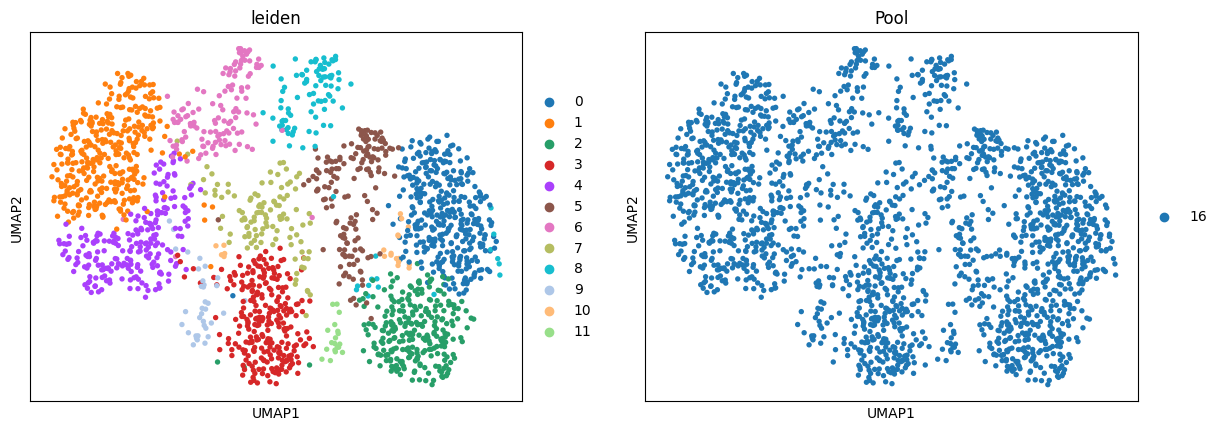

NCIH1299


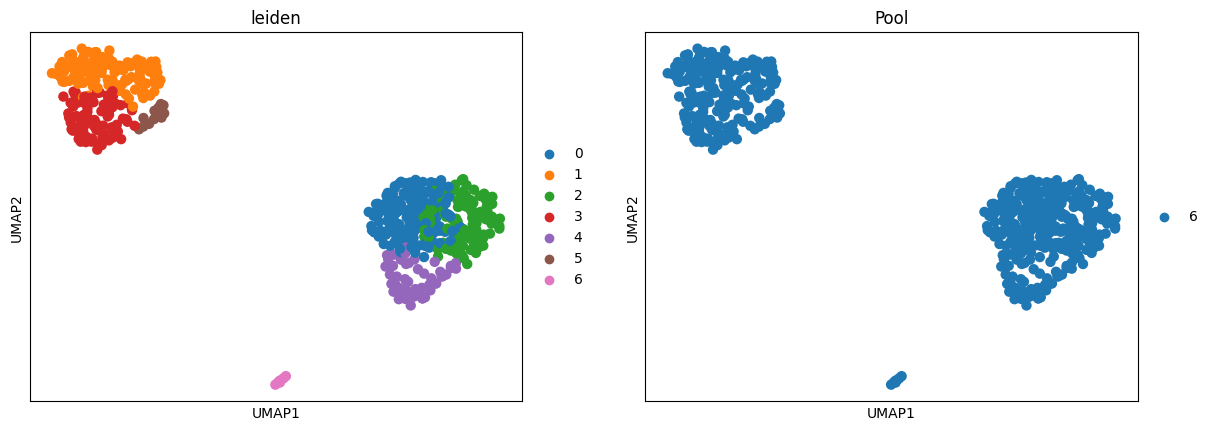

CAKI12


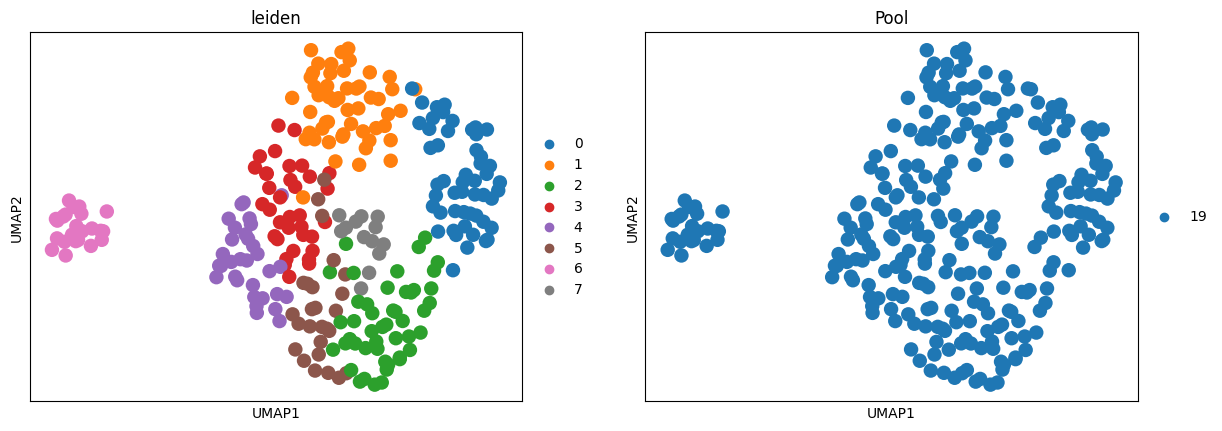

JHU006


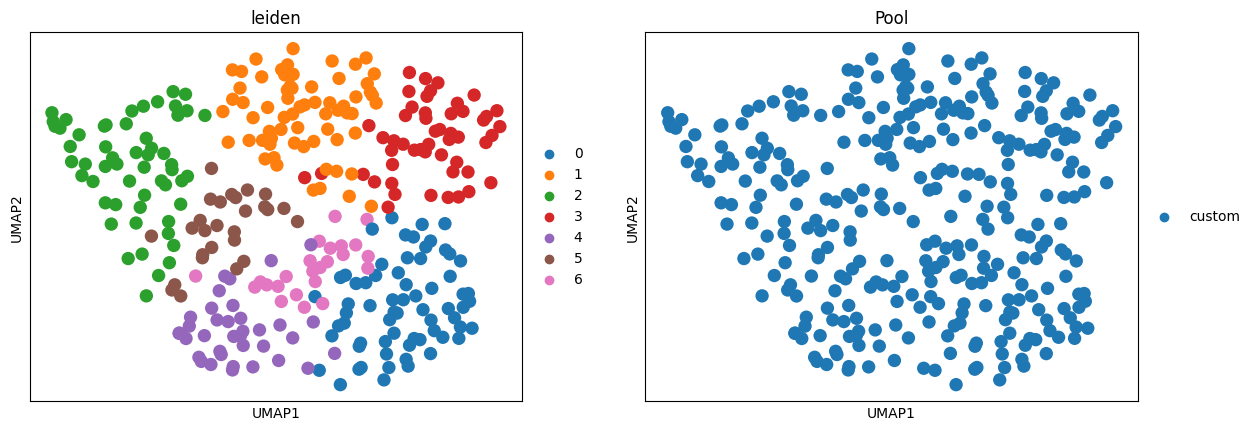

In [ ]:
print("NCIH2110")
sc.pl.umap(adata_NCIH2110, color=['leiden','Pool']) # color by leiden cluster and pool


print("NCIH1299")
sc.pl.umap(adata_NCIH1299, color=['leiden','Pool']) # color by leiden cluster and pool


print("CAKI12")
sc.pl.umap(adata_CAKI2, color=['leiden','Pool']) # color by leiden cluster and pool


print("JHU006")
sc.pl.umap(adata_JHU006, color=['leiden','Pool']) # color by cancer type (indication)


Here we observe some interest patterns and differences with the Kinker tSNE results. Overall, we tended to find much more clusters using the Leiden method when compared to DBSCAN used in Kinker.

For NCIH2110, we expected to see >2 clusters, and Figure 2B shows 4 clusters. However, we found 12 Leiden clusters. In NCIH1299, we observed 7 Leiden clusters, but expected 2 major clusters. In CAKI12, we observed 8 Leiden clusters, but expected 1 major and 1 minor cluster. Lastly, in JHU006, we observed 7 Leiden clusters, but expected 1 cluster.

Importantly, the global structure seems to be similar to Figure 2B. For example, although we observe 8 Leiden clusters for CAKI12, we do see one major cluster (made up of 6 smaller clusters) and 1 minor cluster.

These differences could be due to the different cluster algorithms used by Kinker (DBSCAN) vs here (Leiden). Also, the parameters are much different.

In the next section, we attempt to reduce the granularity of the Leiden clusters by tweaking the nearest neighbours parameter and the resolution parameter to focus more on global structure. This should in theory reduce the number of clusters.



In [ ]:
# increase nearest neighbours to 20
n_neighbors = 20

adata_NCIH2110 = BasicScanpyPreprocessing(adata_NCIH2110, n_top_genes=2000, n_neighbors=n_neighbors, n_pcs=40, random_state=20)
adata_NCIH1299 = BasicScanpyPreprocessing(adata_NCIH1299, n_top_genes=2000, n_neighbors=n_neighbors, n_pcs=40, random_state=20)
adata_CAKI2 = BasicScanpyPreprocessing(adata_CAKI2, n_top_genes=2000, n_neighbors=n_neighbors, n_pcs=40, random_state=20)
adata_JHU006 = BasicScanpyPreprocessing(adata_JHU006, n_top_genes=2000, n_neighbors=n_neighbors, n_pcs=40, random_state=20)

# decrease resolution of leiden

NCIH2110


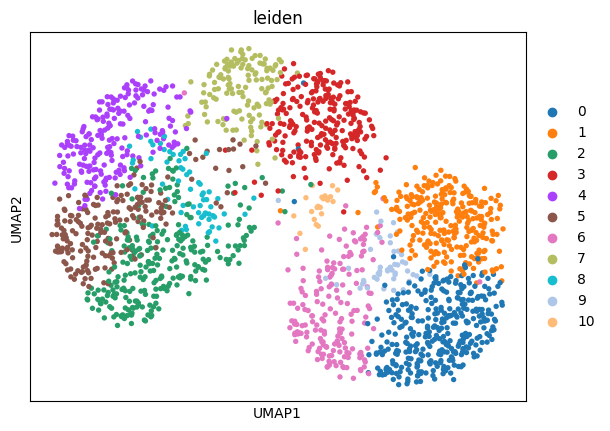

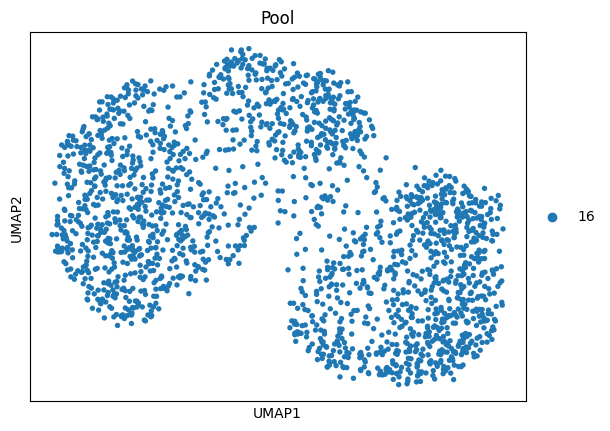

NCIH1299


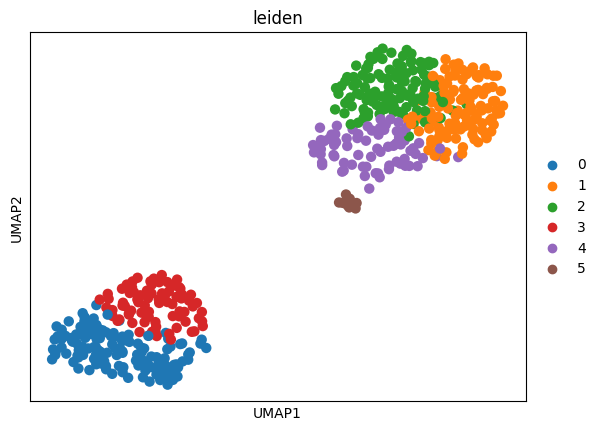

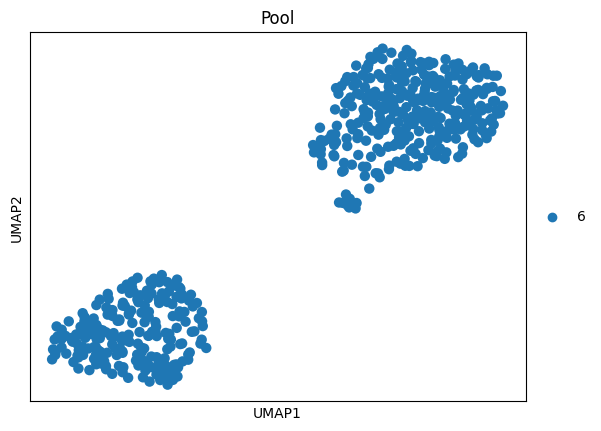

CAKI12


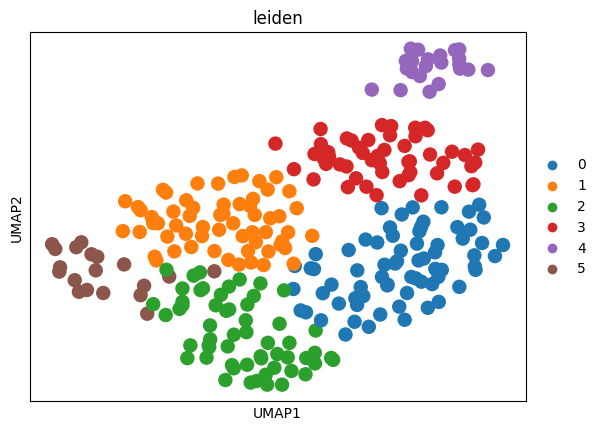

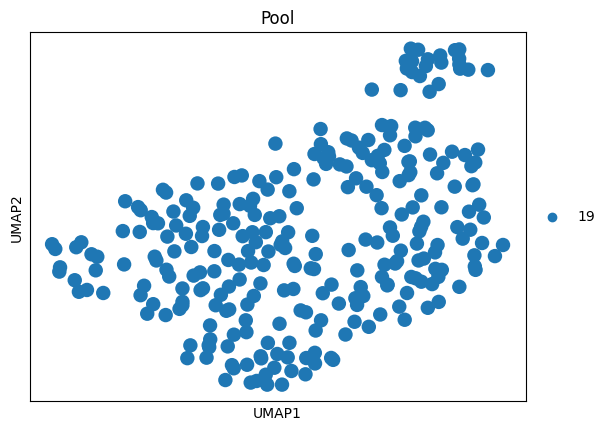

JHU006


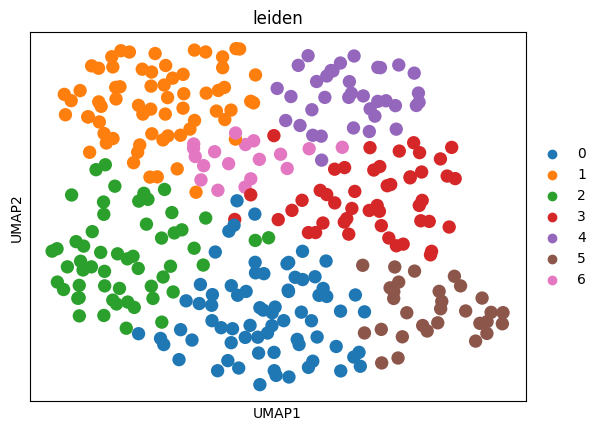

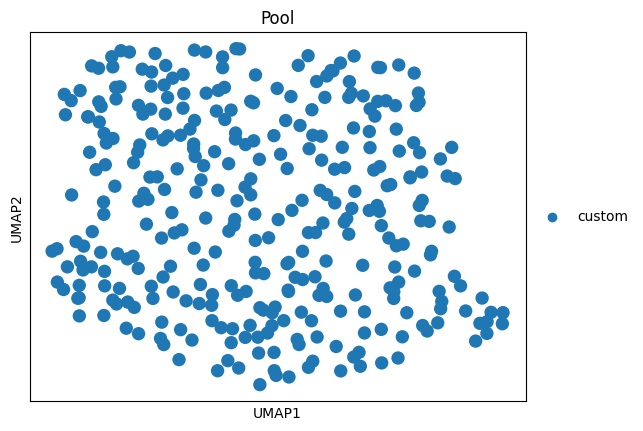

In [ ]:
print("NCIH2110")
sc.pl.umap(adata_NCIH2110, color=['leiden']) # color by cancer type (indication)
sc.pl.umap(adata_NCIH2110, color=['Pool']) # color by cancer type (indication)

print("NCIH1299")
sc.pl.umap(adata_NCIH1299, color=['leiden']) # color by cancer type (indication)
sc.pl.umap(adata_NCIH1299, color=['Pool']) # color by cancer type (indication)

print("CAKI12")
sc.pl.umap(adata_CAKI2, color=['leiden']) # color by cancer type (indication)
sc.pl.umap(adata_CAKI2, color=['Pool']) # color by cancer type (indication)

print("JHU006")
sc.pl.umap(adata_JHU006, color=['leiden']) # color by cancer type (indication)
sc.pl.umap(adata_JHU006, color=['Pool']) # color by cancer type (indication)

## Reproducing Figure 2D

Figure 2D shows a heatmap of gene expression across all the cells belonging to `JHU006`, which is the cell line they found to be quite homogenous with 1 major cluster. Despite this homogeneity, Kinker showed that using NMF based gene programs, variation in the expression of 4 NMF programs could be observed at the single-cell level.

Below I attempt to reproduce this heatmap, while skipping the derivation of the NMF programs in this dataset. Many steps are required to identify the 50 gene signatures that belong to each NMF program, but since these signatures are published in the [supplementary table S3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8135089/bin/NIHMS1697424-supplement-Table_S3.xlsx), we can use that instead of deriving it ourselves.

In [ ]:
# Load the Excel file into a pandas DataFrame
df = pd.read_excel(gdrive_path+'NIHMS1697424-supplement-Table_S3.xlsx')

# Filter the DataFrame to include only the specified RHPs and program
filtered_df = df[df['RHP'].isin(['Cell Cycle - G1/S', 'Cell Cycle - G2/M', 'EMT II', 'Epithelial Senescence']) & \
                 df['Program'].str.startswith('JHU006')]
df
filtered_df

# Create a dictionary to store the gene signatures
gene_signatures = {}

# Iterate through the filtered DataFrame and extract gene signatures
for rhp in filtered_df['RHP'].unique():
    # Extract the top 50 genes for each RHP
    gene_signatures[rhp] = filtered_df[filtered_df['RHP'] == rhp].iloc[:, 3:53].values.flatten().tolist()[:50]

# Print the gene signatures
for rhp, signature in gene_signatures.items():
    print(f'Gene signature for {rhp}:\n{signature}\n')


# check length of each signature
value_lengths = {key: len(value) for key, value in gene_signatures.items()}

# Print the result
print(value_lengths)

Gene signature for Cell Cycle - G2/M:
['CCNB1', 'UBE2C', 'TOP2A', 'AURKA', 'CENPF', 'KPNA2', 'HMMR', 'PLK1', 'AURKB', 'NUSAP1', 'TPX2', 'GTSE1', 'DEPDC1', 'CDK1', 'CKS2', 'CCNB2', 'CDCA3', 'CKAP2', 'NEK2', 'HMGB2', 'MKI67', 'FAM83D', 'BIRC5', 'CDC20', 'CCNA2', 'CENPE', 'PTTG1', 'CDKN3', 'CDCA8', 'CKAP2L', 'PRC1', 'NUF2', 'SGOL2', 'SMC4', 'DLGAP5', 'NDC80', 'KIF20B', 'KIF2C', 'ASPM', 'ARL6IP1', 'PSRC1', 'KNSTRN', 'CENPA', 'KIF23', 'FAM64A', 'ANLN', 'UBE2S', 'PBK', 'HIST1H4C', 'SPC25']

Gene signature for Cell Cycle - G1/S:
['RRM2', 'CDK1', 'SPC25', 'ZWINT', 'CLSPN', 'RAD51AP1', 'DHFR', 'HIST1H4C', 'FEN1', 'FAM111A', 'UBE2T', 'KIAA0101', 'ATAD2', 'DUT', 'PCNA', 'CENPU', 'ASF1B', 'PRIM1', 'SMC2', 'CENPK', 'UBE2C', 'CXCL8', 'SNX10', 'TK1', 'GINS2', 'CENPP', 'FBXO5', 'FAM111B', 'DNMT1', 'ORC6', 'RFC4', 'HIRIP3', 'MCM7', 'FANCL', 'CDC6', 'BRCA1', 'C3orf14', 'RFC5', 'CENPM', 'RNASEH2A', 'CDCA5', 'DNAJC9', 'ACAT2', 'AURKB', 'MAD2L1', 'ESCO2', 'POLD3', 'CKLF', 'RRM1', 'CCDC34']

Gene signature 

Above, we extracted the 50 genes associated with the 4 RHP (NMF programs) needed for the heatmap.

In [ ]:
# remove genes from gene_signatures not in adata_JHU006.varnames

for rhp, signature in gene_signatures.items():
    gene_signatures[rhp] = [gene for gene in signature if gene in adata_JHU006.var_names]

# check length of each signature
value_lengths = {key: len(value) for key, value in gene_signatures.items()}

# Print the result
print(value_lengths)

{'Cell Cycle - G2/M': 50, 'Cell Cycle - G1/S': 49, 'Epithelial Senescence': 50, 'EMT II': 50}


Here, `Cell Cycle - G1/S` signature has 49 members now, as CXCL8 was removed as it was not found in the AnnData object. It is unclear why CXCL8 was not found.

In [ ]:
#list comprehension
my_list = ["a","b","c","d"]

other_list = ["a","d","e","f"]

# modify my_list and keep only values found in other_list

my_list = [letter for letter in my_list if letter in other_list]
print(my_list)


['a', 'd']


categories: 0, 1, 2, etc.
var_group_labels: Cell Cycle - G2/M, Cell Cycle - G1/S, Epithelial Senescence, etc.


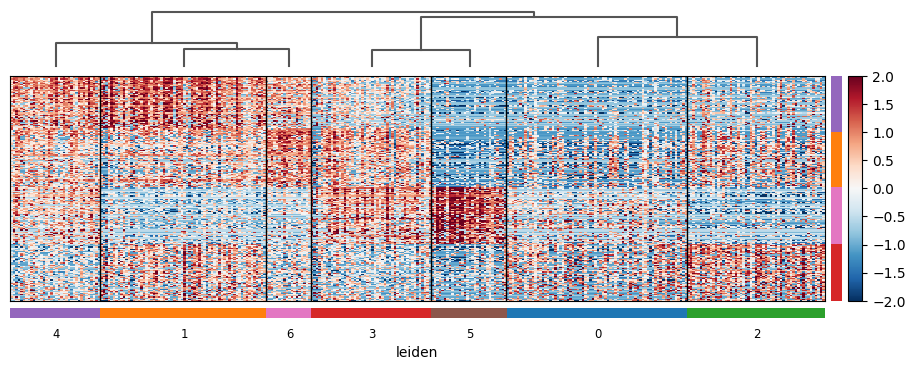

In [ ]:
# scale data and store results in layer
adata_JHU006.layers["scaled"] = sc.pp.scale(adata_JHU006, copy=True).X

# plot heatmap
ax = sc.pl.heatmap(
    adata_JHU006,
    var_names=gene_signatures,
    groupby="leiden",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(11, 4),
       var_group_labels=("a","b","c","d")
    #var_group_labels=("Cell Cycle - G1/S", "Cell Cycle - G2/M", "EMT II", "Epithelial Senescence")
)


The above heatmap is my attempt at reproducing Figure 2D. Note the X-axis should be showing the cells instead of leiden clusters, but I haven't figure out how to do that. The `sc.pl.heatmap()` doesn't allow me to leave `groupby` param empty.

Also, I have hard time labelling the `var_group_labels` corresponding to the 4 NMF programs and we are missing select gene labels as well. Forcing the heatmap to show all gene labels is possible, but would be very cluttered.

categories: 0, 1, 10, etc.
var_group_labels: Cell Cycle - G2/M, Cell Cycle - G1/S, Epithelial Senescence, etc.


KeyError: 'figure'

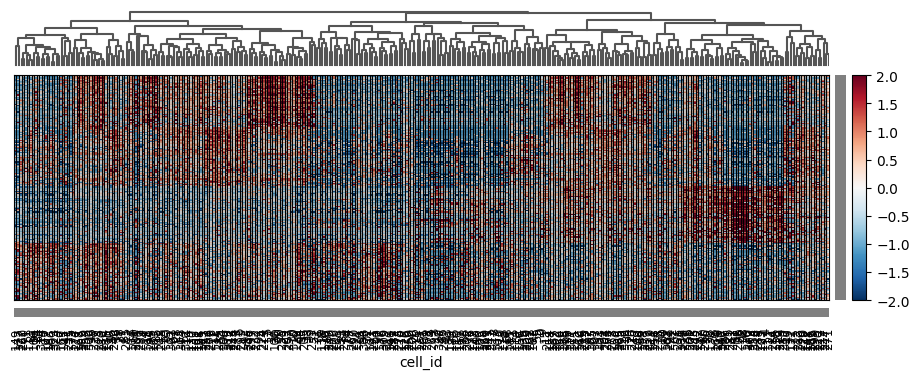

In [ ]:
adata_JHU006.n_obs # number of cells
adata_JHU006.obs["cell_id"] = [str(i) for i in range(adata_JHU006.n_obs)] # add cell_id column
adata_JHU006.obs["cell_id"] = adata_JHU006.obs["cell_id"].astype("category") # convert to categorical
adata_JHU006.obs["cell_id2"] = [i for i in range(adata_JHU006.n_obs)] # add cell_id column
adata_JHU006.obs

# Your heatmap code with modifications
ax_dict = sc.pl.heatmap(
    adata_JHU006,
    var_names=gene_signatures,
    groupby="cell_id",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(11, 4),
    show=False,
   # return_fig=True,
   # show_yticks=False,  # This should hide the y-axis ticks
   # yticklabels=[],     # This should remove the y-axis labels
)


In [ ]:
# Get the figure from the dictionary
fig = ax_dict['figure']

# Iterate through all axes in the figure
for ax in fig.axes:
    # Remove y-axis ticks and labels
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Remove the y-axis label
    ax.set_ylabel('')

    # Remove the tick marks
    ax.tick_params(axis='y', which='both', length=0)

    # If you also want to remove x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.tick_params(axis='x', which='both', length=0)

# Adjust the layout
plt.tight_layout()
# Remove any remaining text elements
for text in fig.findobj(plt.Text):
    text.set_visible(False)
# Display the plot
plt.show()

One potential solution is to make a new group with just the cells and number them numerically.

## Adjusting UMAP Params
    """
    Tweak a parameter of the preprocessing function and visualize the results.

    Parameters:
    -----------
    adata : AnnData
        The original annotated data matrix.
    preprocessing_func : function
        The preprocessing function to use (e.g., ImprovedScanpyPreprocessing).
    param_name : str
        The name of the parameter to tweak.
    param_values : list
        A list of values to try for the specified parameter.
    plot_type : str, optional (default: 'umap')
        The type of plot to generate ('umap' or 'pca').
    save_path : str, optional (default: None)
        Path to save the results. If None, results are not saved.

    Returns:
    --------
    None. Displays plots and optionally saves results.
    """

### Effect of Resolution on Leiden Clustering
Here we can define a more advanced function for pre-processing where we modify the existing `BasicScanpyPreprocessing` function such that additional parameters are considered. Here, we added the resolution param used in Leiden clustering. In additon, a loop was added to execute the Leiden clustering and can test one or more resolutions supplied as a parameter.  

In [ ]:
# advanced function for pre-processing
def AdvancedScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, resolution=1, n_pcs=40, random_state=20):
    sc.pp.normalize_total(adata, target_sum=1e4) # normalize counts to total counts per cell to 1e4
    sc.pp.log1p(adata) # log transform counts
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat') # identify highly variable genes (top 2000)
    #sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack') # perform PCA
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state) # compute nearest neighbors
    sc.tl.umap(adata, random_state=random_state) # compute UMAP embedding

    for res in resolution: # loop through resolutions and add a key for each resolution used for Leiden clustering
      sc.tl.leiden(
          adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, random_state=random_state
      )
    return adata

In [ ]:
# Testing the effect of resolution on Leiden Clustering

# list of different resolutions to test
res = [0.05, 0.10, 0.20, 0.5, 1]

# make a subset copy of AnnData object
adata_JHU006_adv = adata_copy[adata_copy.obs.CellLine.str.contains('JHU006')].copy()
adata_NCIH2110_adv = adata_copy[adata_copy.obs.CellLine.str.contains('NCIH2110')].copy()

# run AdvancedScanpyPreprocessing with different resolution for Leiden Clustering
AdvancedScanpyPreprocessing(adata_JHU006_adv, resolution=res)
AdvancedScanpyPreprocessing(adata_NCIH2110_adv, resolution=res)

AnnData object with n_obs × n_vars = 1990 × 23081
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.50', 'leiden_res_1.00'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.50', 'leiden_res_1.00'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

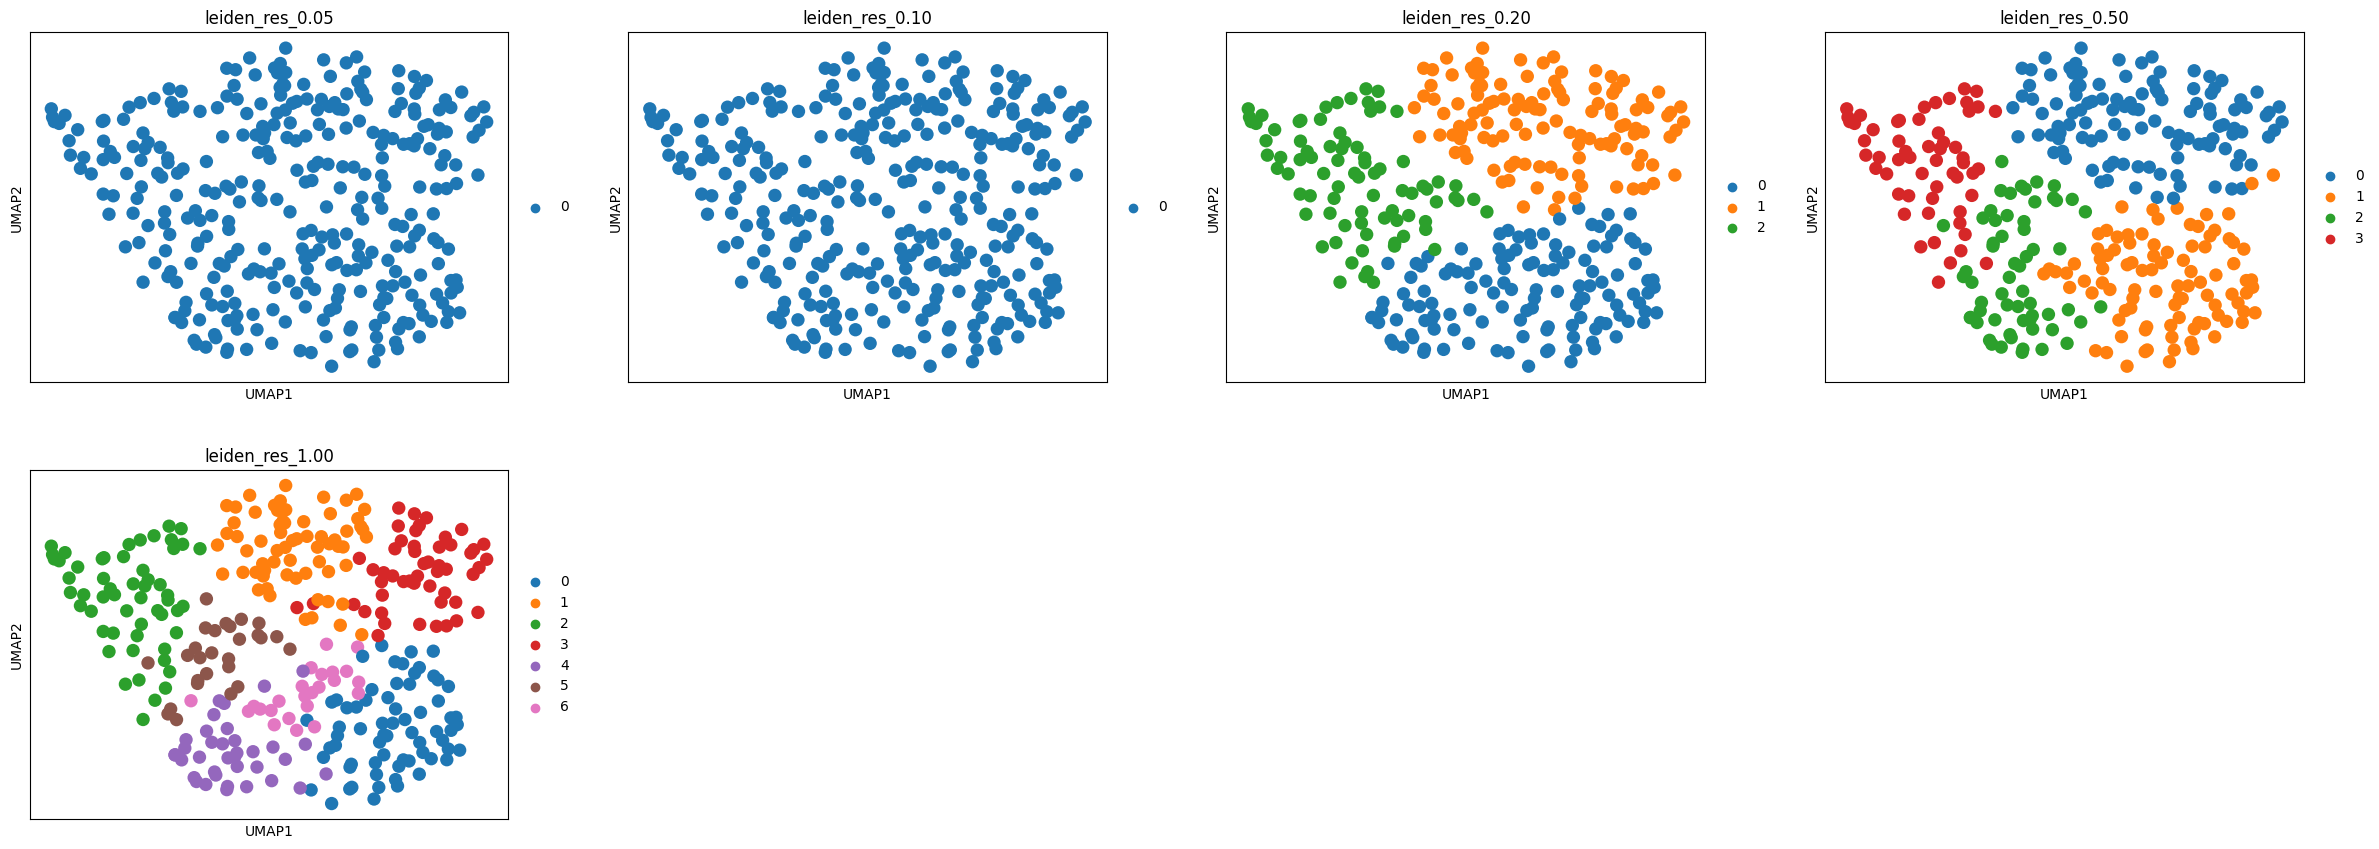

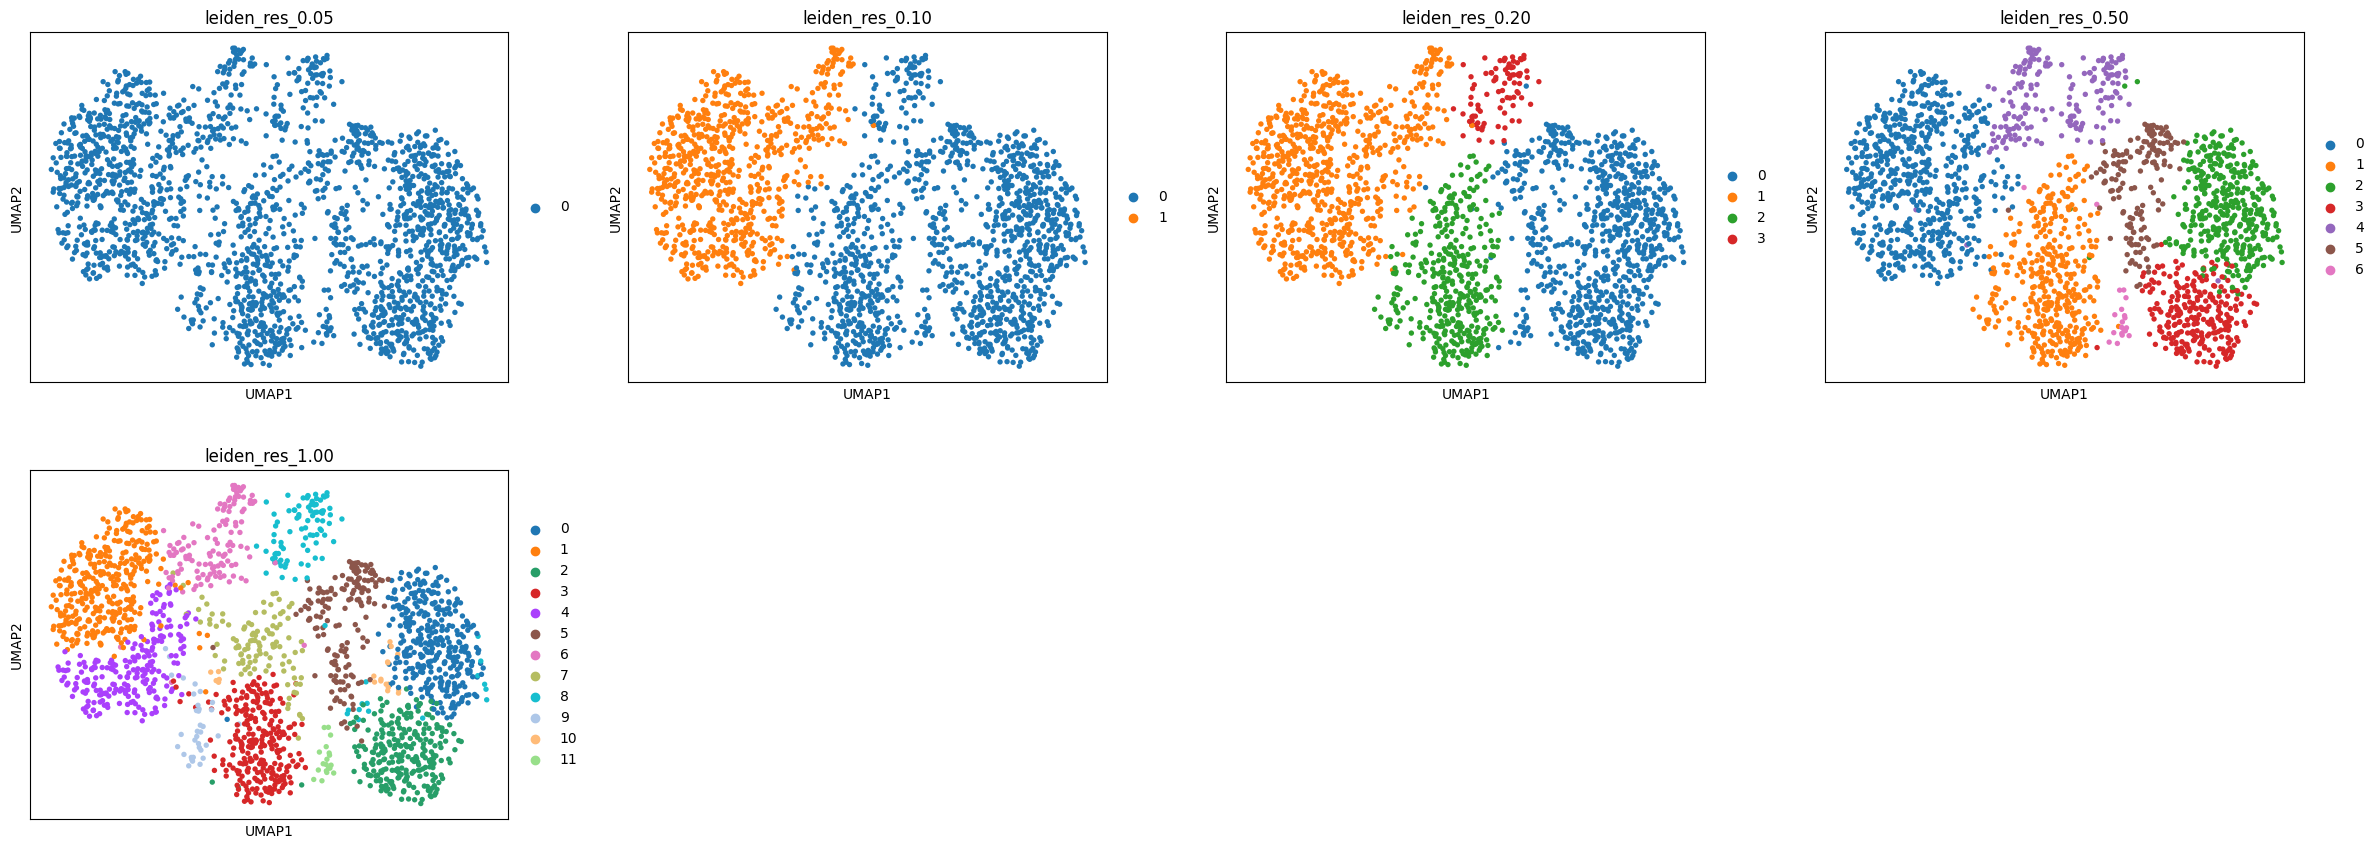

In [ ]:
# Plot UMAP and colorize Leiden clusters generated from diff resolutions tested
sc.pl.umap(adata_JHU006_adv, color=['leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.50', 'leiden_res_1.00'])
sc.pl.umap(adata_NCIH2110_adv, color=['leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.50', 'leiden_res_1.00'])

Here we see that the general effect of lowering the resolution of the Leiden clustering from the default of 1 was able to reduce the number of clusters. Specifically, when `resolution = 0.10` we can observe a singular cluster for `JHU006`, which is similar to what was reported by Kinker. In contrast, that same resolution led to 2 clusters for `NCIH2110`, which is not the same as the 4 clusters reported in Figure 2B. However, a `resolution = 0.20` led to 4 clusters. These differences highlight the tricky nature of adjusting clustering params for generating UMAPs and reproducing data. It is important to note that over interpreting UMAPs has been highly [criticized](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011288) and have started to fall out of favour in recent years.